In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Plot settings
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

In [2]:
# BERT-as-service
!pip install bert-serving-server
!pip install bert-serving-client

    100% |████████████████████████████████| 61kB 5.0MB/s 
    100% |████████████████████████████████| 1.1MB 17.9MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
  Found existing installation: pyzmq 17.0.0
    Uninstalling pyzmq-17.0.0:
      Successfully uninstalled pyzmq-17.0.0
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install git+http://github.com/brendanhasz/dsutils.git
    
from dsutils.encoding import LambdaTransformer
from dsutils.encoding import LambdaFeatures
from dsutils.encoding import NullEncoder
from dsutils.encoding import DateEncoder
from dsutils.encoding import JsonEncoder
from dsutils.encoding import NhotEncoder
from dsutils.encoding import JoinTransformer
from dsutils.encoding import MultiTargetEncoderLOO

from dsutils.ensembling import BaggedRegressor
from dsutils.ensembling import StackedRegressor
from dsutils.models import InterpolatingPredictor

from dsutils.evaluation import permutation_importance_cv
from dsutils.evaluation import plot_permutation_importance
from dsutils.evaluation import top_k_permutation_importances

from dsutils.transforms import Scaler, Imputer

from dsutils.cleaning import DeleteCols
from dsutils.cleaning import KeepOnlyCols
from dsutils.external import BertEncoder

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-ktu5ji9g
  Stored in directory: /tmp/pip-ephem-wheel-cache-9exr40zw/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Data Loading

In [4]:
# Load training data
dtypes = {
  'id':                    'uint16',
  'belongs_to_collection': 'str',
  'budget':                'float32',
  'genres':                'str',
  'homepage':              'str',
  'imdb_id':               'str',
  'original_language':     'str',
  #'original_title':        'str',
  'overview':              'str',
  'popularity':            'float32',
  #'poster_path':           'str',
  'production_companies':  'str',
  'production_countries':  'str',
  'release_date':          'str',
  'runtime':               'float32',
  'spoken_languages':      'str',
  #'status':                'str',
  'tagline':               'str',
  'title':                 'str',
  'Keywords':              'str',
  'cast':                  'str',
  'crew':                  'str',
  'revenue':               'float32',
}
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv',
                    usecols=dtypes.keys(),
                    dtype=dtypes)
del dtypes['revenue']
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv',
                   usecols=dtypes.keys(),
                   dtype=dtypes)
df = pd.concat([train, test], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
# Load imdb scores
dtypes = {
  'imdb_id':    'str',
  'avg_rating': 'float32',
  'num_rating': 'float32',
}
imdb_df = pd.read_csv('../input/box-office-prediction-imbd-scores/imdb_scores.csv',
                      usecols=dtypes.keys(),
                      dtype=dtypes)

## EDA / Data Cleaning

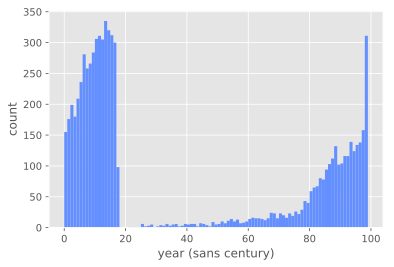

In [6]:
# Histogram of release year (sans century)
year_fn = lambda x: int(x[-2:]) if isinstance(x, str) else np.nan
years = df['release_date'].apply(year_fn)
plt.hist(years, bins=np.arange(100), color='#648FFF')
plt.xlabel('year (sans century)')
plt.ylabel('count')
plt.show()

In [7]:
def fix_dates(date_str):
    if isinstance(date_str, str):
        if int(date_str[-2:]) < 20:
            return date_str[:-2]+'20'+date_str[-2:]
        else:
            return date_str[:-2]+'19'+date_str[-2:]
    else:
        return np.nan
    
# Fix dates
train['release_date'] = train['release_date'].apply(fix_dates)
test['release_date'] = test['release_date'].apply(fix_dates)

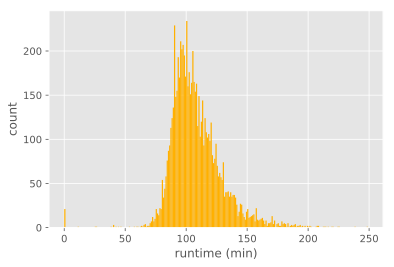

In [8]:
plt.hist(df['runtime'], bins=np.arange(250), color='#FFB000')
plt.xlabel('runtime (min)')
plt.ylabel('count')
plt.show()

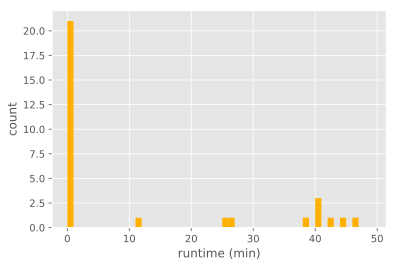

In [9]:
plt.hist(df['runtime'], bins=np.arange(50), color='#FFB000')
plt.xlabel('runtime (min)')
plt.ylabel('count')
plt.show()

In [10]:
df.loc[df['runtime']==0, :]

,Keywords,belongs_to_collection,budget,cast,crew,genres,homepage,id,imdb_id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title
390,NaN,NaN,6843500.0,"[{'cast_id': 2, 'character': 'Alberto', 'credi...","[{'credit_id': '52fe4bb79251416c7510bc79', 'de...","[{'id': 35, 'name': 'Comedy'}]",NaN,391,tt2550838,it,NaN,3.800073,"[{'name': 'Colorado Film Production', 'id': 10...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",12/22/12,10703234.0,0.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,The Worst Christmas of My Life
591,"[{'id': 4897, 'name': 'multiple character'}, {...",NaN,0.0,"[{'cast_id': 8, 'character': '', 'credit_id': ...","[{'credit_id': '52fe4d449251416c911103f5', 'de...","[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,592,tt0768690,ru,NaN,0.402368,"[{'name': 'Роскинопрокат', 'id': 14650}, {'nam...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",12/4/03,234748.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",NaN,А поутру они проснулись
924,"[{'id': 1930, 'name': 'kidnapping'}, {'id': 97...",NaN,0.0,"[{'cast_id': 3, 'character': 'David', 'credit_...","[{'credit_id': '52fe4e31c3a368484e21370b', 'de...","[{'id': 35, 'name': 'Comedy'}]",NaN,925,tt2604346,es,It tells the story of two young friends who mu...,1.926826,"[{'name': 'Televisión Española (TVE)', 'id': 6...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",11/15/13,850259.0,0.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",NaN,¿Quién mató a Bambi?
977,NaN,NaN,11000000.0,"[{'cast_id': 4, 'character': 'Paolo', 'credit_...","[{'credit_id': '52fe4984c3a368484e12f923', 'de...","[{'id': 35, 'name': 'Comedy'}]",NaN,978,tt2076251,it,NaN,5.010563,"[{'name': 'Colorado Film Production', 'id': 10...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",10/27/11,12935800.0,0.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",NaN,La peggior settimana della mia vita
1255,"[{'id': 156212, 'name': 'spaghetti western'}]",NaN,0.0,"[{'cast_id': 14, 'character': 'Onion Stark', '...","[{'credit_id': '52fe493a9251416c750c169b', 'de...","[{'id': 37, 'name': 'Western'}]",NaN,1256,tt0072785,it,Onion Jack (Franco Nero) has bought a piece of...,1.623440,[{'name': 'Compagnia Cinematografica Champion'...,"[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",8/25/75,39598448.0,0.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,"Cry, Onion!"
1541,"[{'id': 642, 'name': 'robbery'}, {'id': 231149...",NaN,750000.0,"[{'cast_id': 3, 'character': 'Viktor', 'credit...","[{'credit_id': '53b7a7b90e0a2676b8006ab6', 'de...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,1542,tt3805180,ru,NaN,0.201582,"[{'name': 'Кинокомпания «Lunapark»', 'id': 420...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",6/5/14,3.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",NaN,All at Once
1874,NaN,NaN,0.0,"[{'cast_id': 2, 'character': 'Murat Hoxha', 'c...","[{'credit_id': '52fe4838c3a36847f815cef1', 'de...","[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://www.vt4.be/vermist,1875,tt1133617,en,Five members of the Missing Persons Task Force...,0.229233,NaN,"[{'iso_3166_1': 'BE', 'name': 'Belgium'}]",1/1/07,1.0,0.0,"[{'iso_639_1': 'nl', 'name': 'Nederlands'}]",NaN,Missing
2150,NaN,NaN,5000000.0,"[{'cast_id': 2, 'character': 'Sasha', 'credit_...","[{'credit_id': '52fe46bec3a368484e0a14f7', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",NaN,2151,tt0477337,ru,NaN,0.414793,"[{'name': 'Kinokompaniya CTB', 'id': 886}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",10/12/06,3919731.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",NaN,Mechenosets
2498,NaN,"[{'id': 106790, 'name': 'Hooked Collection', '...",3500000.0,"[{'cast_id': 10, 'character': 'Vampire', 'cred...","[{'credit_id': '52fe46759251416c91055281', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,2499,tt1620549,ru,The continuation of the adventures of the hero...,0.884241,NaN,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",4/15/10,2294357.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский

In [11]:
# Set runtimes of 0 to nan
train.loc[train['runtime']<1, 'runtime'] = np.nan
test.loc[test['runtime']<1, 'runtime'] = np.nan

In [12]:
# Make id the index
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

In [13]:
# Split into X and Y
train_y = train['revenue']
train_X = train
del train_X['revenue']

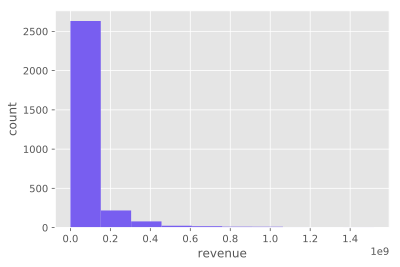

In [14]:
plt.hist(train_y, color='#785EF0')
plt.xlabel('revenue')
plt.ylabel('count')
plt.show()

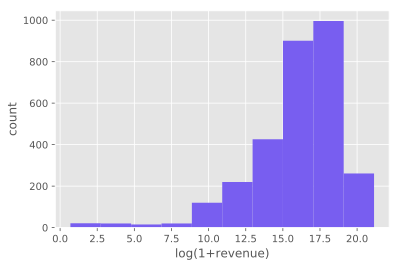

In [15]:
plt.hist(np.log1p(train_y), color='#785EF0')
plt.xlabel('log(1+revenue)')
plt.ylabel('count')
plt.show()

In [16]:
# Transform target
train_y = np.log1p(train_y)

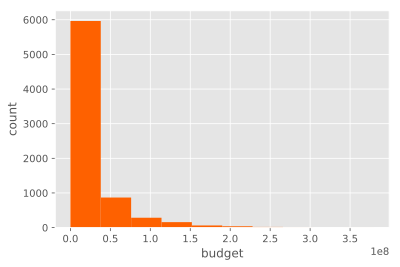

In [17]:
plt.hist(df['budget'], color='#FE6100')
plt.xlabel('budget')
plt.ylabel('count')
plt.show()

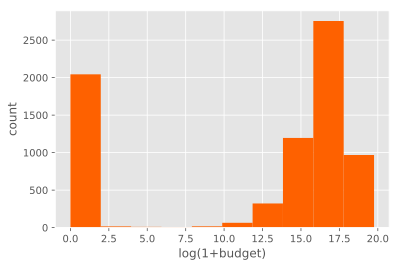

In [18]:
plt.hist(np.log1p(df['budget']), color='#FE6100')
plt.xlabel('log(1+budget)')
plt.ylabel('count')
plt.show()

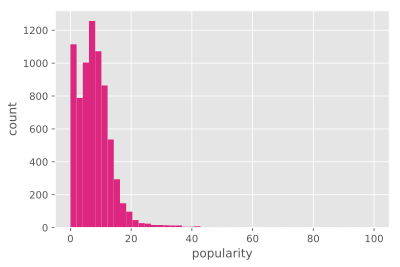

In [19]:
plt.hist(df['popularity'], color='#DC267F', bins=np.linspace(0, 100, 50))
plt.xlabel('popularity')
plt.ylabel('count')
plt.show()

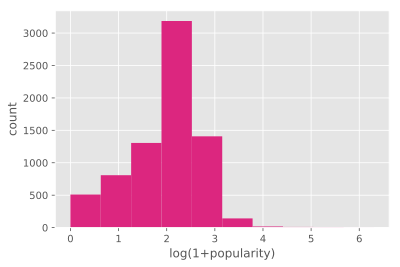

In [20]:
plt.hist(np.log1p(df['popularity']), color='#DC267F')
plt.xlabel('log(1+popularity)')
plt.ylabel('count')
plt.show()

## Processing Pipeline

In [21]:
# Transforms to apply to numeric columns
transforms = {
    'budget': lambda x: np.log1p(x),
    'popularity': lambda x: np.log1p(x),
}

# Columns to null-encode
null_encode_cols = [
    'belongs_to_collection',
    'homepage',
]

# Date encoder
date_cols = {
    'release_date': ('%m/%d/%Y', ['year', 'month', 'day', 'dayofyear', 'dayofweek'])
}

# JSON fields to extract
json_fields = {
    'genres': 'name',
    'production_companies': 'name',
    'production_countries': 'iso_3166_1',
    'spoken_languages': 'iso_639_1',
    'Keywords': 'name',
    'cast': 'name',
    'crew': [('name', 'job', 'Director'),
             ('name', 'job', 'Producer'),
             ('name', 'job', 'Writer'),
             ('name', 'job', 'Editor'),],
}

# Columns to N-hot encode
nhot_cols = [
    'genres_name',
    'original_language',
    'production_countries_iso_3166_1',
    'spoken_languages_iso_639_1',
]

# Columns to target encode
bayesian_c = 5 #regularization
te_cols = [
    'production_companies_name',
    'cast_name',
    'crew_job_Director_name',
    'crew_job_Producer_name',
    'crew_job_Writer_name',
    'crew_job_Editor_name',
]

# Columns to BERT encode
n_pc = 5 #keep top 5 principal components of BERT embeddings
bert_cols = [
    'overview',
    'tagline',
    'title',
    'Keywords_name',
]

# Feature engineering
word_count = lambda e: len(e.split(' ')) if isinstance(e, str) else 0
keyword_count = lambda e: len(e.split(',')) if isinstance(e, str) else 0
new_features = {
    'budget_runtime_ratio': lambda x: x['budget']/x['runtime'],
    'budget_popularity_ratio': lambda x: x['budget']/(x['popularity']+1),
    'budget_year_ratio': lambda x: x['budget']/np.square(x['release_date_year']),
    'popularity_year_ratio': lambda x: x['popularity']/np.square(x['release_date_year']),
    'rating_to_votes_ratio': lambda x: x['avg_rating']/(x['num_rating']+1),
    'runtime_rating_ratio': lambda x: x['runtime']/(x['avg_rating']+1),
    'overview_word_count': lambda x: x['overview'].apply(word_count),
    'tagline_word_count': lambda x: x['tagline'].apply(word_count),
    'keyword_count': lambda x: x['Keywords_name'].apply(keyword_count),
}

In [22]:
# Create the pipeline
preprocessing = Pipeline([
    ('transforms',   LambdaTransformer(transforms)),
    ('join_imbd',    JoinTransformer(imdb_df, 'imdb_id', 'imdb_id')),
    ('null_encoder', NullEncoder(null_encode_cols, delete_old=True)),
    ('date_encoder', DateEncoder(date_cols)),
    ('json_encoder', JsonEncoder(json_fields)),
    ('nhot_encoder', NhotEncoder(nhot_cols, top_n=10)),
    ('add_features', LambdaFeatures(new_features)),
    ('targ_encoder', MultiTargetEncoderLOO(te_cols, bayesian_c=bayesian_c)),
    ('bert_encoder', BertEncoder(bert_cols, n_pc=n_pc)),
    ('scaler',       Scaler()),
    ('imputer',      Imputer()),
])

## Baseline

In [23]:
"""
# Model w/ just catboost + no BERT encoding
model = Pipeline([
    ('transforms',   LambdaTransformer(transforms)),
    ('join_imbd',    JoinTransformer(imdb_df, 'imdb_id', 'imdb_id')),
    ('null_encoder', NullEncoder(null_encode_cols, delete_old=True)),
    ('date_encoder', DateEncoder(date_cols)),
    ('json_encoder', JsonEncoder(json_fields)),
    ('nhot_encoder', NhotEncoder(nhot_cols, top_n=10)),
    ('add_features', LambdaFeatures(new_features)),
    ('targ_encoder', MultiTargetEncoderLOO(te_cols, bayesian_c=bayesian_c)),
    ('delete_cols',  DeleteCols(bert_cols)),
    ('scaler',       Scaler()),
    ('imputer',      Imputer()),
    ('regressor',    CatBoostRegressor(verbose=False))
])
"""

# Model w/ just catboost
model = Pipeline([
    ('preprocessing', preprocessing),
    ('regressor',     CatBoostRegressor(verbose=False))
])

# Fit + make predictions
fit_model = model.fit(train_X, train_y)
preds = fit_model.predict(test)

# Save predictions to file
preds_df = pd.DataFrame(index=test.index)
preds_df['revenue'] = np.maximum(0, np.expm1(preds))
preds_df.to_csv('predictions_baseline.csv')

## Feature Selection

In [24]:
# Preprocess both test and train data
train_pp = preprocessing.fit_transform(train_X, train_y)
test_pp = preprocessing.transform(test)

In [25]:
train_pp

,budget,popularity,runtime,avg_rating,num_rating,belongs_to_collection_isnull,homepage_isnull,release_date_year,release_date_month,release_date_day,release_date_dayofyear,release_date_dayofweek,production_companies_name,cast_name,crew_job_Director_name,crew_job_Producer_name,crew_job_Writer_name,crew_job_Editor_name,genres_name_Drama,genres_name_Comedy,genres_name_Thriller,genres_name_Action,genres_name_Romance,genres_name_Crime,genres_name_Adventure,genres_name_Horror,genres_name_Science Fiction,genres_name_Family,original_language_en,original_language_fr,original_language_ru,original_language_es,original_language_hi,original_language_ja,original_language_it,original_language_cn,original_language_ko,original_language_zh,production_countries_iso_3166_1_US,production_countries_iso_3166_1_GB,...,production_countries_iso_3166_1_RU,spoken_languages_iso_639_1_en,spoken_languages_iso_639_1_fr,spoken_languages_iso_639_1_es,spoken_languages_iso_639_1_de,spoken_languages_iso_639_1_ru,spoken_languages_iso_639_1_it,spoken_languages_iso_639_1_ja,spoken_languages_iso_639_1_zh,spoken_languages_iso_639_1_hi,spoken_languages_iso_639_1_pt,budget_runtime_ratio,budget_popularity_ratio,budget_year_ratio,popularity_year_ratio,rating_to_votes_ratio,runtime_rating_ratio,overview_word_count,tagline_word_count,keyword_count,overview_0,overview_1,overview_2,overview_3,overview_4,tagline_0,tagline_1,tagline_2,tagline_3,tagline_4,title_0,title_1,title_2,title_3,title_4,Keywords_name_0,Keywords_name_1,Keywords_name_2,Keywords_name_3,Keywords_name_4
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.614888,0.066753,-0.726601,-1.371228,-0.294354,-1.991373,0.678536,0.991162,-1.400755,0.573807,-1.336760,0.559405,0.171717,0.016287,0.194221,-0.283138,0.138338,-0.060287,-1.023160,1.382322,-0.598219,-0.573519,-0.485459,-0.430990,-0.414523,-0.334327,-0.327496,-0.308381,0.406191,-0.163355,-0.126139,-0.120568,-0.119139,-0.111726,-0.089786,-0.081910,-0.08191,-0.079822,0.538913,-0.384832,...,-0.141714,0.371787,-0.327031,-0.295233,-0.245150,-0.231795,-0.208332,-0.175426,-0.152791,-0.138365,-0.120978,0.918825,0.516371,0.583834,0.027088,-0.253397,0.204788,-0.828863,0.813727,-0.484381,-0.871375,0.012707,0.101371,-0.129157,-0.708184,-0.150311,-0.531894,0.536552,0.126640,-0.176061,-0.842534,0.673369,0.921789,1.493438,-1.130241,0.002735,-0.325368,1.395342,0.485157,-1.756566
2,0.755958,0.335867,0.223824,-0.681773,-0.073458,-1.991373,0.678536,0.277956,0.359233,-1.047881,0.277093,0.559405,1.910632,1.006831,1.002957,0.464104,0.138338,1.083929,0.977047,1.382322,-0.598219,-0.573519,2.059161,-0.430990,-0.414523,-0.334327,-0.327496,3.241555,0.406191,-0.163355,-0.126139,-0.120568,-0.119139,-0.111726,-0.089786,-0.081910,-0.08191,-0.079822,0.538913,-0.384832,...,-0.141714,0.371787,-0.327031,-0.295233,-0.245150,-0.231795,-0.208332,-0.175426,-0.152791,-0.138365,-0.120978,0.612314,0.512358,0.748607,0.326105,-0.265986,0.661062,0.578076,1.183939,-0.484381,1.060106,-0.859776,0.095378,-0.488031,1.616908,-0.045360,-1.183660,0.590443,0.057292,-0.186768,-1.719168,0.700402,1.255697,0.368860,0.443508,-0.000985,-0.065476,-1.443993,-1.219575,-0.885467
3,0.420698,2.971060,-0.156346,1.977550,3.561993,0.501999,-1.473270,0.926325,0.945896,-0.584541,0.891894,0.559405,0.454283,0.620815,-0.017326,-0.152086,0.138338,-0.268808,0.977047,-0.723169,-0.598219,-0.573519,-0.485459,-0.430990,-0.414523,-0.334327,-0.327496,-0.308381,0.406191,-0.163355,-0.126139,-0.120568,-0.119139,-0.111726,-0.089786,-0.081910,-0.08191,-0.079822,0.538913,-0.384832,...,-0.141714,0.371787,-0.327031,-0.295233,-0.245150,-0.231795,-0.208332,-0.175426,-0.152791,-0.138365,-0.120978,0.445883,-0.398903,0.394169,2.907003,-0.280521,-1.189989,-1.110251,0.628620,0.715696,-0.915027,-0.079514,0.102615,0.008394,0.390866,-0.015778,-0.782867,0.186483,0.600580,-1.933363,0.263880,-0.583228,0.523470,0.304322,-1.026462,0.712696,0.172633,-0.499842,1.053982,0.118334
4,0.284764,-0.736560,0.651515,1.583576,-0.178864,0.5019

In [26]:
%%time

# CatBoost
catboost = Pipeline([
    ('regressor', CatBoostRegressor(verbose=False))
])

# Compute permutation-based feature importances
imp_df = permutation_importance_cv(train_pp,
                                   train_y.copy(),
                                   estimator=catboost,
                                   metric='rmse',
                                   n_jobs=1)

CPU times: user 4min 28s, sys: 13.5 s, total: 4min 42s
Wall time: 2min 36s


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


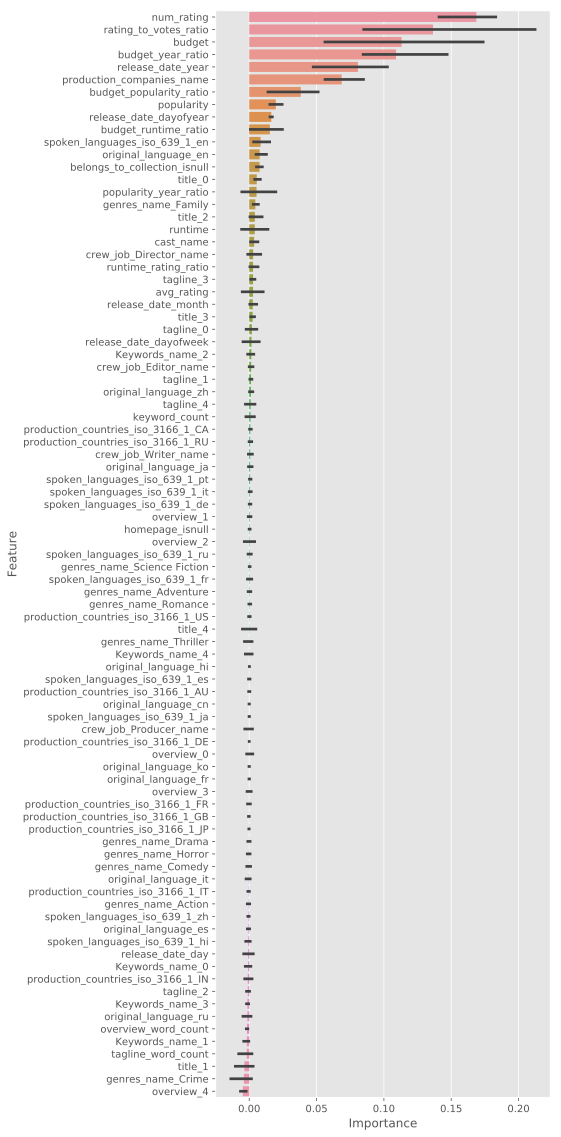

In [27]:
# Show the feature importances
plt.figure(figsize=(6, 20))
plot_permutation_importance(imp_df)
plt.show()

In [28]:
# Get a list of the top 30 most important features
cols_to_keep = top_k_permutation_importances(imp_df, k=30)

## Model

In [29]:
# Add feature selection to preprocessing
preprocessing = Pipeline([
    ('preprocessing', preprocessing),
    ('col_filter',    KeepOnlyCols(cols_to_keep)),
])

In [30]:
# Base learner models
base_learners = [
    BayesianRidge(),
    XGBRegressor(),
    CatBoostRegressor(verbose=False),
    LGBMRegressor()
]

# Stacked model
model = StackedRegressor(base_learners,
                         meta_learner=BayesianRidge(),
                         preprocessing=preprocessing,
                         n_splits=5, n_jobs=1)

In [31]:
%%time

# Fit model and predict on test data
fit_model = model.fit(train_X, train_y)
preds = fit_model.predict(test)

# Save predictions to file
preds_df = pd.DataFrame(index=test.index)
preds_df['revenue'] = np.maximum(0, np.expm1(preds))
preds_df.to_csv('predictions.csv')

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CPU times: user 4min 25s, sys: 28.5 s, total: 4min 53s
Wall time: 4min 11s
